# Diabetes Prediction Model
## Kaggle Playground Series S5E12

Building predictive models based on EDA insights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (700000, 26)
Test shape: (300000, 25)


## 2. Feature Engineering

In [3]:
def create_features(df):
    """Create new features based on EDA insights"""
    df = df.copy()
    
    # BMI categories
    df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100], 
                                 labels=['underweight', 'normal', 'overweight', 'obese'])
    
    # Age groups
    df['age_group'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 100], 
                              labels=['young', 'middle', 'senior', 'elderly'])
    
    # Blood pressure categories (based on systolic)
    df['bp_category'] = pd.cut(df['systolic_bp'], bins=[0, 120, 130, 140, 200], 
                                labels=['normal', 'elevated', 'high_stage1', 'high_stage2'])
    
    # Cholesterol ratios
    df['ldl_hdl_ratio'] = df['ldl_cholesterol'] / (df['hdl_cholesterol'] + 1)
    df['total_hdl_ratio'] = df['cholesterol_total'] / (df['hdl_cholesterol'] + 1)
    df['non_hdl_cholesterol'] = df['cholesterol_total'] - df['hdl_cholesterol']
    
    # Risk score combining medical history
    df['medical_risk_score'] = (df['family_history_diabetes'] + 
                                 df['hypertension_history'] + 
                                 df['cardiovascular_history'])
    
    # Activity score (inverse of screen time, scaled by physical activity)
    df['activity_score'] = df['physical_activity_minutes_per_week'] / (df['screen_time_hours_per_day'] + 1)
    
    # Lifestyle score (diet + sleep + physical activity - screen time - alcohol)
    df['lifestyle_score'] = (df['diet_score'] + 
                              df['sleep_hours_per_day'] + 
                              df['physical_activity_minutes_per_week'] / 60 - 
                              df['screen_time_hours_per_day'] - 
                              df['alcohol_consumption_per_week'])
    
    # Blood pressure difference (pulse pressure)
    df['pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']
    
    # Mean arterial pressure
    df['mean_arterial_pressure'] = df['diastolic_bp'] + (df['pulse_pressure'] / 3)
    
    # Age * BMI interaction (both top predictors)
    df['age_bmi_interaction'] = df['age'] * df['bmi']
    
    # Physical activity per day
    df['physical_activity_per_day'] = df['physical_activity_minutes_per_week'] / 7
    
    return df

# Apply feature engineering
train_fe = create_features(train)
test_fe = create_features(test)

print(f"New train shape: {train_fe.shape}")
print(f"New test shape: {test_fe.shape}")
print(f"\nNew features created: {train_fe.shape[1] - train.shape[1]}")

New train shape: (700000, 39)
New test shape: (300000, 38)

New features created: 13


## 3. Prepare Features for Modeling

In [4]:
# Define feature columns
categorical_cols = ['gender', 'ethnicity', 'education_level', 'income_level', 
                    'smoking_status', 'employment_status', 'bmi_category', 
                    'age_group', 'bp_category']

# All columns except id, target, and categorical
exclude_cols = ['id', 'diagnosed_diabetes'] + categorical_cols
numerical_cols = [col for col in train_fe.columns if col not in exclude_cols]

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")

Categorical columns (9): ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'bmi_category', 'age_group', 'bp_category']

Numerical columns (28): ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'ldl_hdl_ratio', 'total_hdl_ratio', 'non_hdl_cholesterol', 'medical_risk_score', 'activity_score', 'lifestyle_score', 'pulse_pressure', 'mean_arterial_pressure', 'age_bmi_interaction', 'physical_activity_per_day']


In [5]:
# Encode categorical variables
label_encoders = {}
train_encoded = train_fe.copy()
test_encoded = test_fe.copy()

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined data to handle all categories
    combined = pd.concat([train_encoded[col].astype(str), test_encoded[col].astype(str)])
    le.fit(combined)
    train_encoded[col] = le.transform(train_encoded[col].astype(str))
    test_encoded[col] = le.transform(test_encoded[col].astype(str))
    label_encoders[col] = le

print("Categorical encoding complete!")

Categorical encoding complete!


In [6]:
# Prepare X and y
feature_cols = numerical_cols + categorical_cols
X = train_encoded[feature_cols]
y = train_encoded['diagnosed_diabetes']
X_test = test_encoded[feature_cols]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTarget distribution:\n{y.value_counts(normalize=True)}")

X shape: (700000, 37)
y shape: (700000,)
X_test shape: (300000, 37)

Target distribution:
diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64


## 4. Model Training with Cross-Validation

In [7]:
# Cross-validation setup
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

def train_and_evaluate(model, X, y, X_test, model_name, cat_features=None):
    """Train model with cross-validation and return OOF predictions and test predictions"""
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if model_name == 'catboost' and cat_features:
            model.fit(X_train, y_train, eval_set=(X_val, y_val), 
                     cat_features=cat_features, verbose=False)
        elif model_name == 'lightgbm':
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                     callbacks=[lgb.early_stopping(50, verbose=False)])
        elif model_name == 'xgboost':
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        else:
            model.fit(X_train, y_train)
        
        # Predictions
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        test_preds += model.predict_proba(X_test)[:, 1] / N_FOLDS
        
        # Score
        score = roc_auc_score(y_val, val_preds)
        scores.append(score)
        print(f"  Fold {fold+1}: AUC = {score:.5f}")
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"\n  Mean AUC: {mean_score:.5f} (+/- {std_score:.5f})")
    
    return oof_preds, test_preds, mean_score

### 4.1 LightGBM

In [8]:
print("Training LightGBM...")
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose': -1
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_oof, lgb_test, lgb_score = train_and_evaluate(lgb_model, X, y, X_test, 'lightgbm')

Training LightGBM...
  Fold 1: AUC = 0.72640
  Fold 1: AUC = 0.72640
  Fold 2: AUC = 0.72481
  Fold 2: AUC = 0.72481
  Fold 3: AUC = 0.72561
  Fold 3: AUC = 0.72561
  Fold 4: AUC = 0.72664
  Fold 4: AUC = 0.72664
  Fold 5: AUC = 0.72689

  Mean AUC: 0.72607 (+/- 0.00076)
  Fold 5: AUC = 0.72689

  Mean AUC: 0.72607 (+/- 0.00076)


### 4.2 XGBoost

In [9]:
print("Training XGBoost...")
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'random_state': 42,
    'tree_method': 'hist'
}

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_oof, xgb_test, xgb_score = train_and_evaluate(xgb_model, X, y, X_test, 'xgboost')

Training XGBoost...
  Fold 1: AUC = 0.72576
  Fold 1: AUC = 0.72576
  Fold 2: AUC = 0.72453
  Fold 2: AUC = 0.72453
  Fold 3: AUC = 0.72534
  Fold 3: AUC = 0.72534
  Fold 4: AUC = 0.72675
  Fold 4: AUC = 0.72675
  Fold 5: AUC = 0.72565

  Mean AUC: 0.72560 (+/- 0.00071)
  Fold 5: AUC = 0.72565

  Mean AUC: 0.72560 (+/- 0.00071)


### 4.3 CatBoost

In [10]:
print("Training CatBoost...")
cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'verbose': False
}

cat_model = CatBoostClassifier(**cat_params)
cat_features_idx = [X.columns.get_loc(col) for col in categorical_cols]
cat_oof, cat_test, cat_score = train_and_evaluate(cat_model, X, y, X_test, 'catboost', 
                                                   cat_features=cat_features_idx)

Training CatBoost...
  Fold 1: AUC = 0.72459
  Fold 1: AUC = 0.72459
  Fold 2: AUC = 0.72289
  Fold 2: AUC = 0.72289
  Fold 3: AUC = 0.72391
  Fold 3: AUC = 0.72391
  Fold 4: AUC = 0.72492
  Fold 4: AUC = 0.72492
  Fold 5: AUC = 0.72471

  Mean AUC: 0.72420 (+/- 0.00074)
  Fold 5: AUC = 0.72471

  Mean AUC: 0.72420 (+/- 0.00074)


## 5. Model Comparison & Ensemble

MODEL COMPARISON
LightGBM: 0.72607
XGBoost: 0.72560
CatBoost: 0.72420


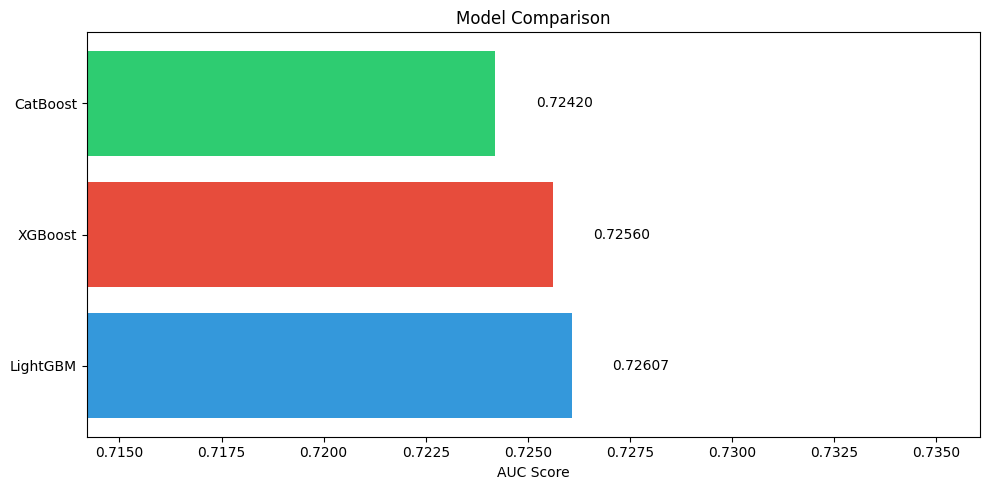

In [11]:
# Compare model scores
print("=" * 50)
print("MODEL COMPARISON")
print("=" * 50)
results = {
    'LightGBM': lgb_score,
    'XGBoost': xgb_score,
    'CatBoost': cat_score
}

for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.5f}")

# Visualize
plt.figure(figsize=(10, 5))
plt.barh(list(results.keys()), list(results.values()), color=['#3498db', '#e74c3c', '#2ecc71'])
plt.xlabel('AUC Score')
plt.title('Model Comparison')
plt.xlim(min(results.values()) - 0.01, max(results.values()) + 0.01)
for i, (name, score) in enumerate(results.items()):
    plt.text(score + 0.001, i, f'{score:.5f}', va='center')
plt.tight_layout()
plt.show()

In [12]:
# Create ensemble (weighted average based on CV scores)
total_score = lgb_score + xgb_score + cat_score
lgb_weight = lgb_score / total_score
xgb_weight = xgb_score / total_score
cat_weight = cat_score / total_score

print(f"Ensemble weights:")
print(f"  LightGBM: {lgb_weight:.3f}")
print(f"  XGBoost:  {xgb_weight:.3f}")
print(f"  CatBoost: {cat_weight:.3f}")

# Ensemble OOF predictions
ensemble_oof = lgb_weight * lgb_oof + xgb_weight * xgb_oof + cat_weight * cat_oof
ensemble_score = roc_auc_score(y, ensemble_oof)
print(f"\nEnsemble OOF AUC: {ensemble_score:.5f}")

# Ensemble test predictions
ensemble_test = lgb_weight * lgb_test + xgb_weight * xgb_test + cat_weight * cat_test

Ensemble weights:
  LightGBM: 0.334
  XGBoost:  0.333
  CatBoost: 0.333

Ensemble OOF AUC: 0.72638


## 6. Feature Importance

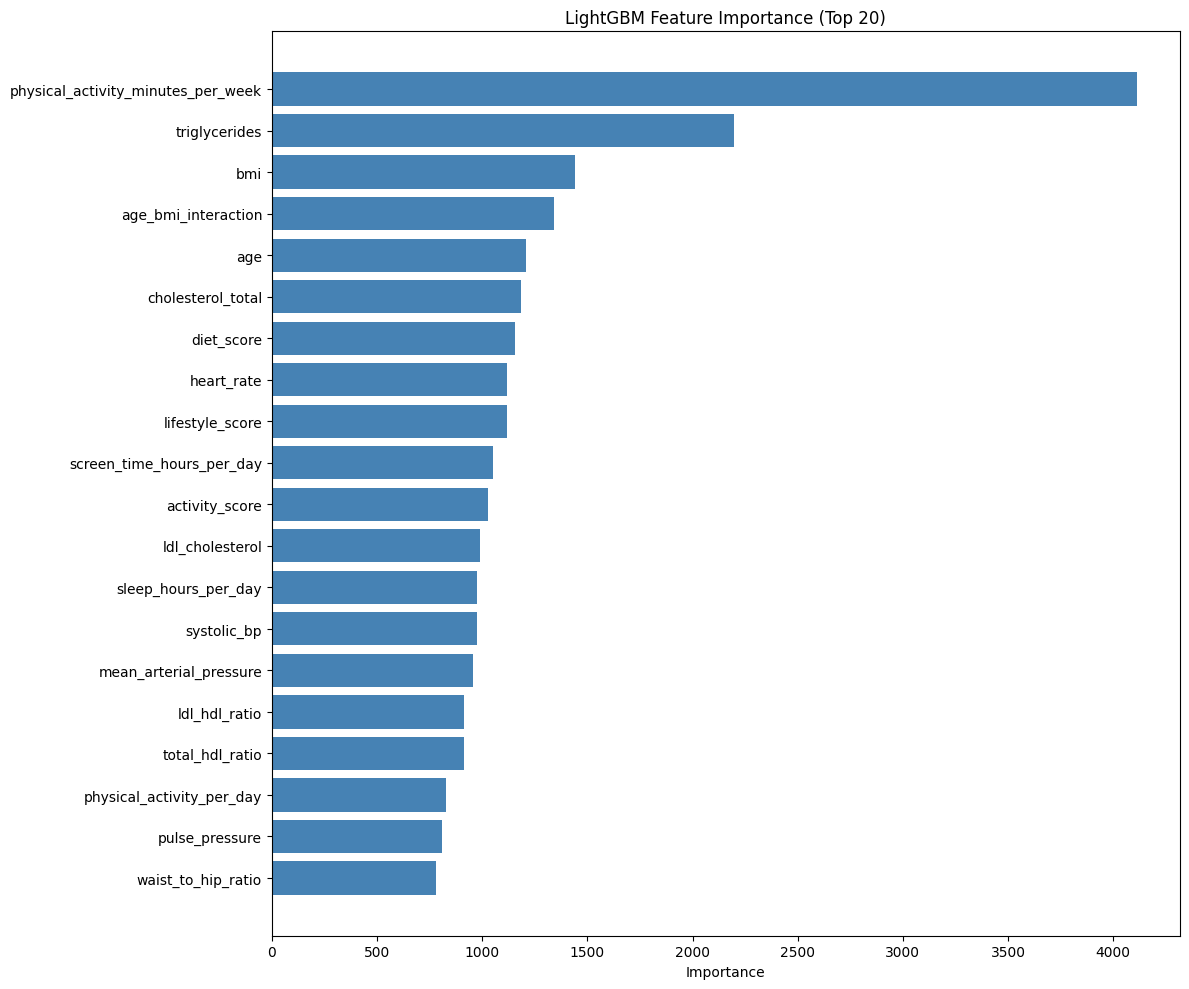


Top 10 Features:
                           feature  importance
physical_activity_minutes_per_week        4112
                     triglycerides        2199
                               bmi        1442
               age_bmi_interaction        1341
                               age        1209
                 cholesterol_total        1184
                        diet_score        1155
                        heart_rate        1119
                   lifestyle_score        1116
         screen_time_hours_per_day        1051


In [13]:
# LightGBM feature importance
lgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
plt.barh(lgb_importance['feature'][:20], lgb_importance['importance'][:20], color='steelblue')
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance (Top 20)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(lgb_importance.head(10).to_string(index=False))

## 7. Create Submission

Submission shape: (300000, 2)

Submission head:
       id  diagnosed_diabetes
0  700000            0.506150
1  700001            0.673835
2  700002            0.775000
3  700003            0.398225
4  700004            0.925581

Prediction statistics:
count    300000.000000
mean          0.601365
std           0.190845
min           0.044896
25%           0.463937
50%           0.606069
75%           0.745487
max           0.991473
Name: diagnosed_diabetes, dtype: float64


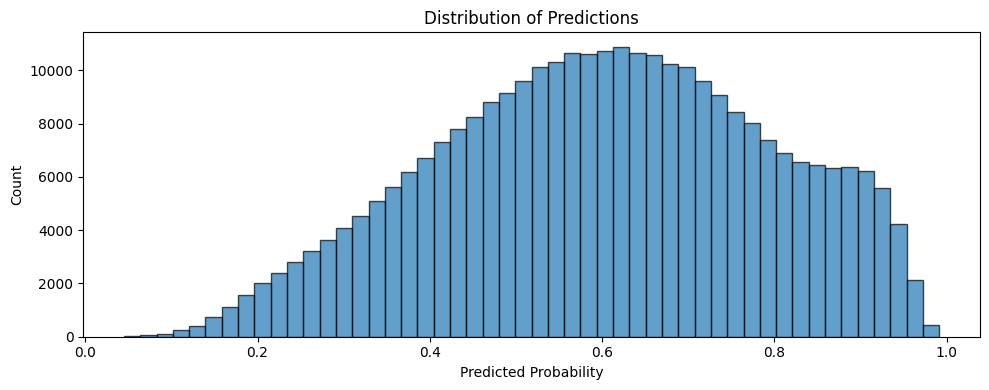

In [14]:
# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'diagnosed_diabetes': ensemble_test
})

# Check submission
print("Submission shape:", submission.shape)
print("\nSubmission head:")
print(submission.head())
print("\nPrediction statistics:")
print(submission['diagnosed_diabetes'].describe())

# Distribution of predictions
plt.figure(figsize=(10, 4))
plt.hist(submission['diagnosed_diabetes'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Distribution of Predictions')
plt.tight_layout()
plt.show()

In [15]:
# Save submission
submission.to_csv('submission.csv', index=False)
print("✅ Submission saved to 'submission.csv'")

# Also save individual model submissions
submission_lgb = pd.DataFrame({'id': test['id'], 'diagnosed_diabetes': lgb_test})
submission_lgb.to_csv('submission_lgb.csv', index=False)

submission_xgb = pd.DataFrame({'id': test['id'], 'diagnosed_diabetes': xgb_test})
submission_xgb.to_csv('submission_xgb.csv', index=False)

submission_cat = pd.DataFrame({'id': test['id'], 'diagnosed_diabetes': cat_test})
submission_cat.to_csv('submission_cat.csv', index=False)

print("✅ Individual model submissions also saved")

✅ Submission saved to 'submission.csv'
✅ Individual model submissions also saved
✅ Individual model submissions also saved


## 8. Summary

In [ ]:
print("=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"\n📊 Cross-Validation Scores (AUC):")
print(f"   LightGBM:  {lgb_score:.5f}")
print(f"   XGBoost:   {xgb_score:.5f}")
print(f"   CatBoost:  {cat_score:.5f}")
print(f"   Ensemble:  {ensemble_score:.5f}")
print(f"\n🏆 Best Single Model: {max(results, key=results.get)} ({max(results.values()):.5f})")
print(f"\n📁 Files Created:")
print(f"   - submission.csv (ensemble)")
print(f"   - submission_lgb.csv")
print(f"   - submission_xgb.csv")
print(f"   - submission_cat.csv")
print(f"\n🚀 To submit to Kaggle, run:")
print(f"   kaggle competitions submit -c playground-series-s5e12 -f submission.csv -m 'Ensemble model'")

FINAL RESULTS SUMMARY

📊 Cross-Validation Scores (AUC):
   LightGBM:  0.72607
   XGBoost:   0.72560
   CatBoost:  0.72420
   Ensemble:  0.72638

🏆 Best Single Model: LightGBM (0.72607)

📁 Files Created:
   - submission.csv (ensemble)
   - submission_lgb.csv
   - submission_xgb.csv
   - submission_cat.csv

🚀 To submit to Kaggle, run:
   kaggle competitions submit -c playground-series-s5e12 -f submission.csv -m 'Ensemble model'


: 